In [3]:
from pyomo.environ import *
import random
from pyomo.opt import SolverFactory

model = ConcreteModel()

#  Definición de conjuntos
model.D = Set(initialize=['CD1', 'CD2', 'CD3'])
model.C = Set(initialize=['C1', 'C2', 'C3', 'C4'])
model.V = Set(initialize=['V1', 'V2', 'V3'])
model.N = model.D | model.C


# Definición de parámetros
depot_capacity = {'CD1':20000, 'CD2':50000, 'CD3':30000}
demand = {'C1':50, 'C2':80, 'C3':65, 'C4':70}

vehicle_capacity = {'V1':100, 'V2':80, 'V3':150} # capacidad máxima del vehículo 
vehicle_range = {'V1':120, 'V2':100, 'V3':150} # rango máximo en kilómetros


nodes = list(model.N) 
cost = {} 

for i in nodes: 
    for j in nodes: 
        if i != j: 
            cost[(i, j)] = random.randint(1, 7) # valor de ejemplo 
        else: 
            cost[(i, j)] = 999
        
model.cost = Param(model.N, model.N, initialize=lambda model, i, j: cost[(i, j)], within=NonNegativeReals)

# Variables de decisión y auxiliares

model.x = Var(model.V, model.N, model.N, domain=Binary)
model.y = Var(model.V, model.D, domain=Binary)
model.u = Var(model.V, model.C, domain=NonNegativeReals)

# funcion objetivo

def obj_rule(model): 
    return sum(model.cost[i,j] * model.x[v,i,j] for v in model.V for i in model.N for j in model.N if i != j) 

model.obj = Objective(rule=obj_rule, sense=minimize)

# Restricciones

def assign_depot_rule(model, v): 
    return sum(model.y[v,d] for d in model.D) == 1 

model.assign_depot = Constraint(model.V, rule=assign_depot_rule)

def depot_uniqueness_rule(model, d): 
    return sum(model.y[v,d] for v in model.V) <= 1 

model.depot_uniqueness = Constraint(model.D, rule=depot_uniqueness_rule)

def start_route_rule(model, v, d): 
    return sum(model.x[v, d, j] for j in model.N if j != d) == model.y[v,d] 

model.start_route = Constraint(model.V, model.D, rule=start_route_rule)

def return_route_rule(model, v, d): 
    return sum(model.x[v, i, d] for i in model.N if i != d) == model.y[v,d] 

model.return_route = Constraint(model.V, model.D, rule=return_route_rule)

def flow_conservation_rule(model, v, i): 
    if i in model.C: 
        return sum(model.x[v, j, i] for j in model.N if j != i) == \
               sum(model.x[v, i, j] for j in model.N if j != i)
    else:
        return Constraint.Skip 
    
model.flow_conservation = Constraint(model.V, model.N, rule=flow_conservation_rule)

def no_depot_to_depot_rule(model, v, i, j): 
    if i in model.D and j in model.D and i != j: 
        return model.x[v,i,j] == 0
    else:
        return Constraint.Skip 

model.no_depot_travel = Constraint(model.V, model.N, model.N, rule=no_depot_to_depot_rule)

def customer_visit_rule(model, i): 
    if i in model.C: 
        return sum(model.x[v, j, i] for v in model.V for j in model.N if j != i) == 1 
    else:
        return Constraint.Skip 

model.customer_visit = Constraint(model.N, rule=customer_visit_rule)

def vehicle_capacity_rule(model, v):
    return sum(demand[i] * sum(model.x[v, j, i] for j in model.N if j != i) for i in model.C) <= vehicle_capacity[v]

model.vehicle_capacity = Constraint(model.V, rule=vehicle_capacity_rule)

def depot_capacity_rule(model, v):
    return sum(demand[i] * sum(model.x[v, j, i] for j in model.N if j != i) for i in model.C) <= sum(model.y[v,d] * depot_capacity[d] for d in model.D) 

model.depot_capacity = Constraint(model.V, rule=depot_capacity_rule)

def vehicle_range_rule(model, v):
    return sum(model.cost[i,j] * model.x[v,i,j] for i in model.N for j in model.N if i != j) <= vehicle_range[v] 

model.vehicle_range = Constraint(model.V, rule=vehicle_range_rule)

def mtz_rule(model, v, i, j):
    if i != j: 
        return model.u[v,i] - model.u[v,j] + vehicle_capacity[v] * model.x[v,i,j] <= vehicle_capacity[v] - demand[j] 
    return Constraint.Skip

model.mtz = Constraint(model.V, model.C, model.C, rule=mtz_rule)

def mtz_bounds_rule(model, v, i): 
    return (demand[i], model.u[v,i], vehicle_capacity[v])

model.mtz_bounds = Constraint(model.V, model.C, rule=mtz_bounds_rule)

def demand_satisfaction_rule(model, v, i): 
    return model.u[v,i] >= demand[i] * sum(model.x[v, j, i] for j in model.N if j != i) 

model.demand_satisfaction = Constraint(model.V, model.C, rule=demand_satisfaction_rule)

solver = SolverFactory('glpk') 
results = solver.solve(model) 
#results.write()

print("\nRutas óptimas:") 
for v in model.V: 
    assigned_depot = [d for d in model.D if value(model.y[v,d]) > 0.5] 
    print("Vehículo", v, "asignado a bodega(s):", assigned_depot) 
    for i in model.N: 
        for j in model.N: 
            if i != j and value(model.x[v,i,j]) > 0.5: 
                print(" de", i, "a", j)
                


Rutas óptimas:
Vehículo V1 asignado a bodega(s): ['CD3']
 de CD3 a C4
 de C4 a CD3
Vehículo V2 asignado a bodega(s): ['CD2']
 de CD2 a C1
 de C1 a CD2
Vehículo V3 asignado a bodega(s): ['CD1']
 de CD1 a C3
 de C2 a CD1
 de C3 a C2


🚚 Vehículo V1 (desde CD3) recorrió 2 km
🚚 Vehículo V2 (desde CD2) recorrió 7 km
🚚 Vehículo V3 (desde CD1) recorrió 7 km


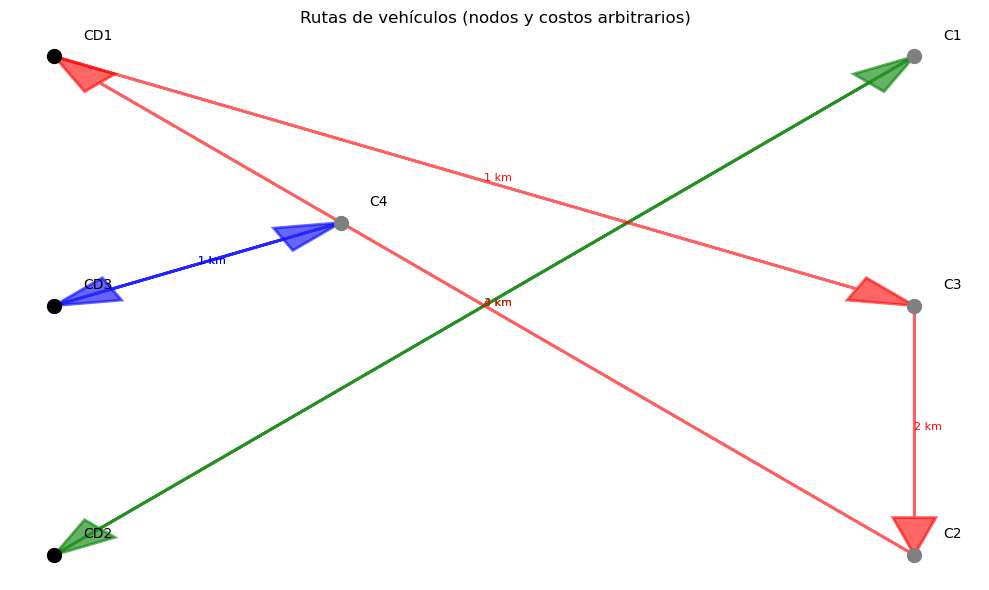

In [4]:
import matplotlib.pyplot as plt

# Posiciones arbitrarias para visualización (x, y)
positions = {
    'CD1': (1, 4),
    'CD2': (1, 1),
    'CD3': (1, 2.5),
    'C1':  (4, 4),
    'C2':  (4, 1),
    'C3':  (4, 2.5),
    'C4':  (2, 3),
}

# Colores por vehículo
vehicle_colors = {
    'V1': 'blue',
    'V2': 'green',
    'V3': 'red',
}

plt.figure(figsize=(10, 6))

# Dibujar nodos
for node, (x, y) in positions.items():
    # Colores distintos para bodegas
    color = 'black' if node.startswith("CD") else 'gray'
    plt.plot(x, y, 'o', markersize=10, color=color)
    plt.text(x + 0.1, y + 0.1, node, fontsize=10)

# Dibujar rutas y mostrar distancias
for v in model.V:
    color = vehicle_colors[v]
    total_distance = 0
    for i in model.N:
        for j in model.N:
            if i != j and value(model.x[v, i, j]) > 0.5:
                x_i, y_i = positions[i]
                x_j, y_j = positions[j]
                # Dibujar flecha
                plt.arrow(x_i, y_i, x_j - x_i, y_j - y_i,
                          head_width=0.15, length_includes_head=True,
                          color=color, alpha=0.6, linestyle='-', linewidth=2)

                # Mostrar distancia sobre la flecha
                mid_x = (x_i + x_j) / 2
                mid_y = (y_i + y_j) / 2
                dist = cost[(i, j)]
                plt.text(mid_x, mid_y, f"{dist} km", fontsize=8, color=color)

                # Sumar distancia al total
                total_distance += dist

    # Mostrar distancia total recorrida por el vehículo
    depot = [d for d in model.D if value(model.y[v, d]) > 0.5]
    if total_distance > 0:
        print(f"🚚 Vehículo {v} (desde {depot[0] if depot else 'desconocida'}) recorrió {total_distance} km")

# Mostrar gráfico
plt.title("Rutas de vehículos (nodos y costos arbitrarios)")
plt.axis('off')
plt.tight_layout()
plt.show()
